## Анализ A/B-теста с помощью линеаризованных лайков

### Описание данных

С 3 сентября по 9 сентября 2022 года параллельно проходили два эксперимента рекомендации постов. Для этого пользователи были разбиты на 4 группы.  
* 1 эксперимент:  

    - 1 группа - контрольная, нет никаких изменений;
    - 2 группа - пользователям показывается рекомендация "похожих на лайкнутые посты".
* 2 эксперимент:
    - 0 группа - контрольная, нет никаких изменений в системе рекомендаций;
    - 3 группа - пользователям показывается рекомендация "постовб которые лайкнули похожие на вас люди".

### Расчет метрики

Вычисляется общий CTR в контрольной группе: $$ CTRcontrol = \frac {sum(likes)}{sum(views)} $$

В каждой из групп рассчитывается поюзерная метрика: $$ \text{linearized likes} = likes - CTRcontrol*views $$

Проведем анализ результатов A/B-теста с помощью линеаризованных лайков для 1 и 2 экспериментов и сравним полученные данных с метрикой поюзерного СTR.

### Загрузка данных для анализа 2 эксперимента

In [1]:
import pandahouse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [2]:
with open('db.txt') as file:
    host, password, user, database =(i.rstrip() for i in file.readlines())

In [3]:
connection = {'host':host,
              'password': password,
              'user':user,
              'database':database
             }

Отбираем данные с 3 по 9 сентября 2022 года для 2 эксперимента (0 и 3 группы).

In [4]:
q = """
select exp_group, user_id,
sum(action='like') as likes, 
sum(action='view') as views,
likes/views as ctr
from {db}.feed_actions
where exp_group in(0, 3)
and time::date between '2022-09-03' and '2022-09-09'
group by exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)

In [5]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,33,120,0.275000
1,3,123580,10,59,0.169492
2,3,2709,4,25,0.160000
3,0,61827,4,8,0.500000
4,0,80745,22,108,0.203704


In [6]:
df.exp_group.value_counts()

3    17085
0    17054
Name: exp_group, dtype: int64

Количество пользователей в тестовой и контрольной группах примерно равно.  
Посмотри на распеделение поюерного СTR.

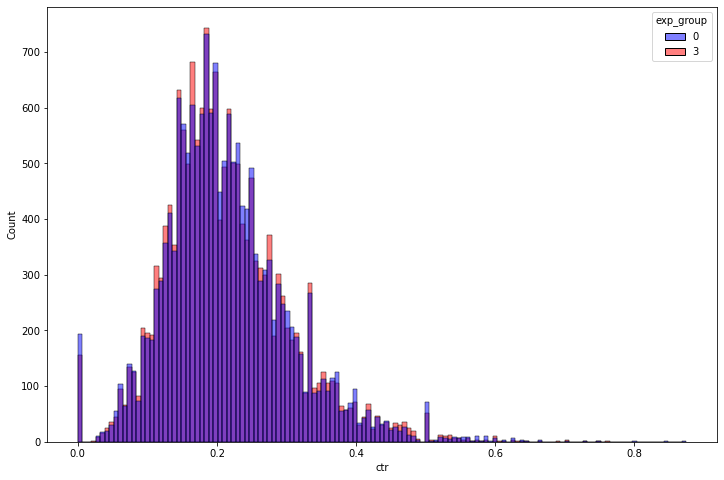

In [7]:
plt.figure(figsize=(12,8))
sns.histplot(data=df, x= 'ctr', hue='exp_group', palette=['b', 'r'], alpha =0.5);

Проведем сравнение групп Т критерием Стьюдента, уровень значимости примем равным 0.05.

In [8]:
st.ttest_ind(df[df.exp_group == 0].ctr,
            df[df.exp_group == 3].ctr, equal_var=False)

Ttest_indResult(statistic=0.5051875755480856, pvalue=0.613430357624797)

Итак, мы не можем отклонить нулевую гипотезу о равенстве средних в группах.  
Теперь попробуем сравнить группы с помощью метрики линеализованных лайков.

Вычислим общий CTR в контрольной группу по формуле:  $$ CTRcontrol = \frac {sum(likes)}{sum(views)} $$

In [9]:
CTR_control = sum(df[df.exp_group == 0].likes)/sum(df[df.exp_group == 0].views)

Посчитаем поюзерную метрику в обеих группах $$ \text{linearized likes} = likes - CTRcontrol*views $$

In [10]:
df['lin_likes'] = df.likes - CTR_control*df.views

Посмотрим на распределение получившейся метрики

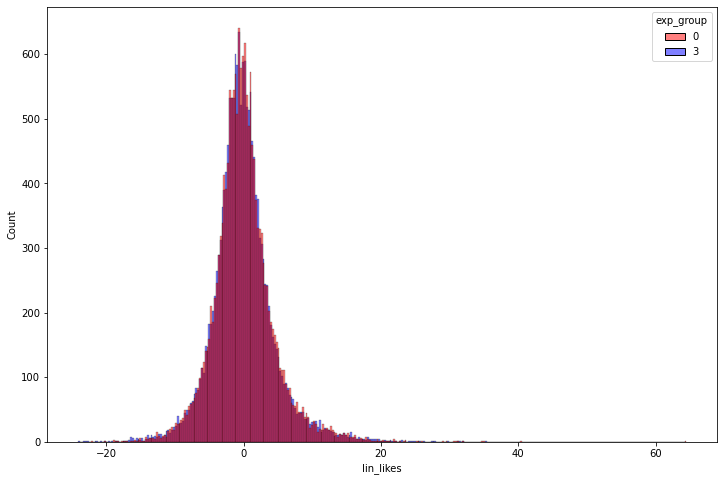

In [11]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='lin_likes', hue='exp_group', palette=['r', 'b']);

Итак, распределение линеализованных лайков в обеих группах больше похоже на нормальное, чем распределение поюзерных CTR.

In [13]:
st.ttest_ind(df[df.exp_group==0].lin_likes, df[df.exp_group==3].lin_likes, equal_var=False)

Ttest_indResult(statistic=1.4652971996296535, pvalue=0.1428490608083239)

P-value при использовании т-теста на линеализованных лайках показал меньшее значение, однако остался выше принятого уровня значимости 0.05. Что говорит о невозможности опровергнуть гипотезу о равенстве групп.

### Анализ данных 1 эксперимента

Подгрузим данные о первом эксперименте (1 и 2 группы).

In [14]:
q = """
select exp_group, user_id, sum(action='like') as likes,
sum(action='view') as views,
likes/views as ctr
from {db}.feed_actions
where exp_group in (1, 2)
and time::date between '2022-09-03' and '2022-09-09'
group by exp_group, user_id
"""
df2 = pandahouse.read_clickhouse(q, connection=connection)

In [15]:
df2.head()

,exp_group,user_id,likes,views,ctr
0,2,78186,6,20,0.300000
1,1,18392,23,104,0.221154
2,1,163747,38,99,0.383838
3,1,85848,6,22,0.272727
4,2,149215,4,32,0.125000


In [16]:
df2.exp_group.value_counts()

1    17070
2    16869
Name: exp_group, dtype: int64

Количество наблюдений в группах примерно равно.

Визуализируем данные

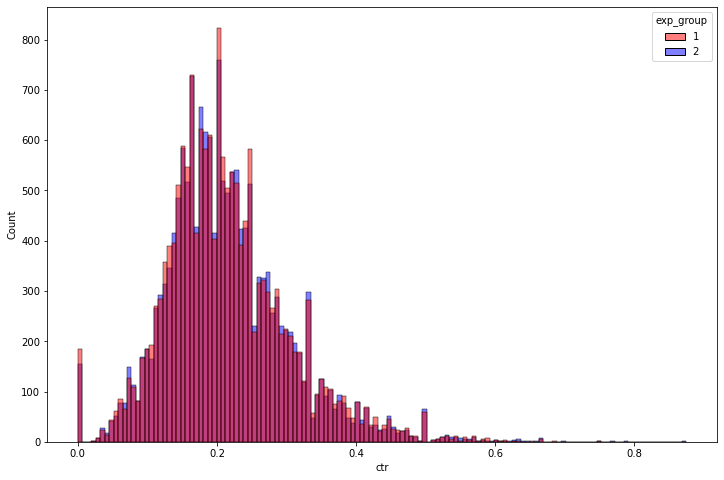

In [17]:
plt.figure(figsize=(12,8))
sns.histplot(data = df2, x= 'ctr', hue='exp_group', palette=['r', 'b']);

Визуально никаких отличий между группами не заметно. Проведем t-тест на поюзерном CTR.

In [18]:
st.ttest_ind(df2[df2.exp_group ==1].ctr, 
            df2[df2.exp_group == 2].ctr,
            equal_var=False)

Ttest_indResult(statistic=-0.41347637473349386, pvalue=0.6792602410005473)

Значение p-value также не дает нам опровергнуть нулевую гипотезу.  
Сравним отличия в группах с помощью t-теста на линеализованных данных.

In [19]:
CTRcontrol2 = sum(df2[df2.exp_group ==1].likes)/sum(df2[df2.exp_group ==1].views)

In [20]:
df2['lin_likes']  = df['likes'] - CTRcontrol2*df['views']

Визуализируем получившуюся метрику.

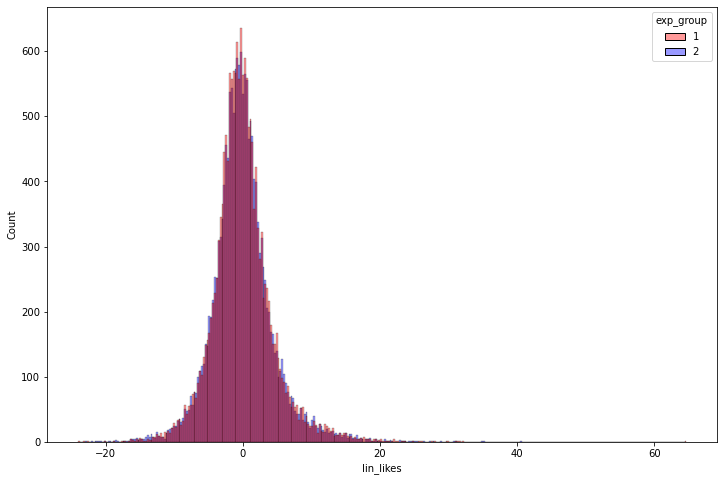

In [21]:
plt.figure(figsize=(12, 8))
sns.histplot(data= df2, x= 'lin_likes', hue='exp_group', palette= ['r', 'b'], alpha =0.4);

In [22]:
st.ttest_ind(df2[df2.exp_group == 1].lin_likes,
            df2[df2.exp_group == 2].lin_likes,
            equal_var=False)

Ttest_indResult(statistic=0.6884481250463613, pvalue=0.4911753358189789)

### Вывод

Никаких статистически значимых различий при анализе результатов ни первого, ни второго экспериментов не обнаружено. Даже более чуствительная метрика линеализованных лайков не "прокрасилась". Значит, внедрение систем рекомендаций не привело к увеличению пользовательского интереса к постам. Следовательно, ни первый, ни второй алгоритмы рекомендаций не нужно запускать в продакшн.